<a href="https://colab.research.google.com/github/mihreteab-ak/FUTURE_ML_03/blob/main/FUTURE_ML_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import & config

In [ ]:
import re
import json
from collections import Counter
import pandas as pd
import numpy as np

import spacy
from spacy.matcher import PhraseMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

nltk.download('punkt')
nltk.download('stopwords')

try:
  from sentence_transformers import SentenceTransformer
  S2_AVAILABLE = True
except Exception:
  S2_AVAILABLE = False

nlp = spacy.load("en_core_web_sm", disable=["parser"])
print("setence-transformers available:", S2_AVAILABLE)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


setence-transformers available: True


Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Resume.csv')

df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


Detect columns

In [ ]:
text_cols = [c for c in df.columns if df[c].dtype == 'object']

col_len = {c: df[c].fillna('').str.len().mean() for c in text_cols}

sorted_text_cols = sorted(col_len.items(), key=lambda x: x[1], reverse=True)

print("Candidate text columns (likely resume text first):")
for c, l in sorted_text_cols:
    print(f" - {c}: mean length {l:.1f}")


RESUME_COL = sorted_text_cols[0][0] if sorted_text_cols else text_cols[0]
ID_COL = "ID"

print("\nDefaults set:")
print("RESUME_COL =", RESUME_COL)
print("ID_COL =", ID_COL)


Candidate text columns (likely resume text first):
 - Resume_html: mean length 15711.2
 - Resume_str: mean length 6295.3
 - Category: mean length 9.5

Defaults set:
RESUME_COL = Resume_html
ID_COL = ID


Text cleaning

In [ ]:
from bs4 import BeautifulSoup
from sklearn.preprocessing import MultiLabelBinarizer
import re
import unicodedata
import pandas as pd

CLEAN_COL = RESUME_COL + "_plain"
SKILLS = [
    "python","java","c++","c#","javascript","react","angular","nodejs","django","flask",
    "sql","postgresql","mysql","mongodb","tensorflow","pytorch","keras","scikit-learn",
    "machine learning","deep learning","natural language processing","nlp","docker","kubernetes",
    "aws","azure","gcp","git","linux","html","css","matlab","marketing","customer service",
    "human resources","payroll","training"
]
REPLACEMENTS = {"c++":"cplusplus","c#":"csharp","node.js":"nodejs","scikit learn":"scikit-learn","nlp":"natural language processing"}

def html_to_text(html):
    if not isinstance(html, str):
        return ""
    soup = BeautifulSoup(html, "html.parser")
    for t in soup(["script","style"]):
        t.decompose()
    text = soup.get_text(separator=" ")
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_text(s):
    s = s.lower()
    for k,v in REPLACEMENTS.items():
        s = s.replace(k, v)
    s = re.sub(r'[^a-z0-9\-\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def get_skills_section(text):
    if not text:
        return ""
    lower = text.lower()
    headings = ["skills","technical skills","skills & abilities","areas of expertise"]
    for hk in headings:
        idx = lower.find(hk)
        if idx != -1:
            start = idx + len(hk)
            snippet = text[start:start + 700]
            m = re.search(r'(experience|education|projects|certifications|accomplishments|summary)', snippet, flags=re.I)
            if m:
                snippet = snippet[:m.start()]
            return snippet.strip()
    return ""

def find_skills(text, skills):
    text_norm = normalize_text(text)
    found = set()
    for sk in skills:
        sk_norm = normalize_text(sk)
        pattern = r'\b' + re.escape(sk_norm) + r'\b'
        if re.search(pattern, text_norm):
            found.add(sk_norm)
    return sorted(found)

df[CLEAN_COL] = df[RESUME_COL].fillna('').astype(str).apply(html_to_text)
df['skills_section_hint'] = df[CLEAN_COL].apply(get_skills_section)

def extract_skills_for_row(row):
    hint = row.get('skills_section_hint','') or ""
    if hint.strip():
        found = find_skills(hint, SKILLS)
        if found:
            return found
    return find_skills(row.get(CLEAN_COL,""), SKILLS)

df['extracted_skills'] = df.apply(extract_skills_for_row, axis=1)
df['num_skills'] = df['extracted_skills'].apply(len)

mlb = MultiLabelBinarizer(sparse_output=False)
skill_matrix = mlb.fit_transform(df['extracted_skills'])
skill_df = pd.DataFrame(skill_matrix, columns=[f"skill__{s}" for s in mlb.classes_])
df = pd.concat([df.reset_index(drop=True), skill_df.reset_index(drop=True)], axis=1)

print(f"Cleaned {len(df)} resumes from column: {RESUME_COL}")
print(f"Clean text column created: {CLEAN_COL}")
print(f"Detected skills vocabulary size: {len(mlb.classes_)}")
display(df[[RESUME_COL, CLEAN_COL, 'skills_section_hint', 'extracted_skills', 'num_skills']].head(6))



Cleaned 2484 resumes from column: Resume_html
Clean text column created: Resume_html_plain
Detected skills vocabulary size: 34


,Resume_html,Resume_html_plain,skills_section_hint,extracted_skills,num_skills
0,"<div class=""fontsize fontface vmargins hmargin...",HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...,"as well as computer skills, knowledge of medic...","[customer service, human resources, payroll]",3
1,"<div class=""fontsize fontface vmargins hmargin...","HR SPECIALIST, US HR OPERATIONS Summary Versat...","Adobe Photoshop, ADP, Asset Management, brandi...",[marketing],1
2,"<div class=""fontsize fontface vmargins hmargin...",HR DIRECTOR Summary Over 20 years experience i...,Recruiting FMLA/EEO/FLSA HRIS Development Bene...,"[customer service, human resources, marketing,...",5
3,"<div class=""fontsize fontface vmargins hmargin...","HR SPECIALIST Summary Dedicated, Driven, and D...",Type 50 wpm and 10-Key by touch Microsoft prog...,[customer service],1
4,"<div class=""fontsize fontface vmargins hmargin...",HR MANAGER Skill Highlights HR SKILLS HR Depar...,HR Department Startup Three New Organization S...,[training],1
5,"<div class=""fontsize fontface vmargins hmargin...",HR GENERALIST Summary Dedicated and focused Ad...,"administrative, Administrative Assistant, bi, ...","[human resources, training]",2


Job description, vectorization and similarity



In [ ]:
JD_COL = "Category"

if JD_COL and JD_COL in df.columns:
    job_desc_text = df[JD_COL].dropna().astype(str).iloc[0]
else:
    job_desc_text = """
    We are hiring a Machine Learning Engineer with experience in Python, PyTorch, TensorFlow,
    NLP, Docker, Kubernetes, AWS, and SQL. Experience with scikit-learn and data pipelines is required.
    """

print("Job description used:")
print(job_desc_text[:240])

corpus = df[CLEAN_COL].fillna('').tolist() + [job_desc_text]
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
vecs = tfidf.fit_transform(corpus)
resume_vecs = vecs[:-1]
jd_vec = vecs[-1]
cos_sim = cosine_similarity(resume_vecs, jd_vec.reshape(1, -1)).flatten()
df['cosine_sim_tfidf'] = cos_sim
print("TF-IDF similarity computed.")


Job description used:
HR
TF-IDF similarity computed.


Scoring

In [ ]:
required_skills = ["python","natural language processing","pytorch","tensorflow"]  # edit as needed
nice_to_have = ["docker","kubernetes","aws","sql"]

def calc_skill_scores(extracted_list):
    extracted = set(extracted_list)
    req_matched = [s for s in required_skills if s in extracted]
    nice_matched = [s for s in nice_to_have if s in extracted]
    req_score = len(req_matched) / max(1, len(required_skills))
    nice_score = len(nice_matched) / max(1, len(nice_to_have))
    return req_score, nice_score, req_matched, nice_matched

out = df['extracted_skills'].apply(calc_skill_scores)
df['req_score'] = out.apply(lambda x: x[0])
df['nice_score'] = out.apply(lambda x: x[1])
df['req_matched'] = out.apply(lambda x: x[2])
df['nice_matched'] = out.apply(lambda x: x[3])
df['missing_required'] = df['req_matched'].apply(lambda x: [s for s in required_skills if s not in x])

w_cos = 0.5
w_req = 0.4
w_nice = 0.1

sim_col = 'cosine_sim_emb' if 'cosine_sim_emb' in df.columns else 'cosine_sim_tfidf'
df['final_score'] = (w_cos * df[sim_col]) + (w_req * df['req_score']) + (w_nice * df['nice_score'])

ranked = df.sort_values('final_score', ascending=False).reset_index(drop=True)
display_cols = [ID_COL if ID_COL else RESUME_COL, 'final_score', sim_col, 'req_score', 'nice_score', 'num_skills', 'missing_required', 'req_matched']
print("Top 20 candidates:")
display(ranked[display_cols].head(20))

ranked.to_csv("resume_ranking_output.csv", index=False)
print("Saved ranking to resume_ranking_output.csv")


Top 20 candidates:


,ID,final_score,cosine_sim_tfidf,req_score,nice_score,num_skills,missing_required,req_matched
0,62994611,0.225000,0.000000,0.50,0.25,15,"[natural language processing, pytorch]","[python, tensorflow]"
1,17812897,0.214504,0.429009,0.00,0.00,1,"[python, natural language processing, pytorch,...",[]
2,21297521,0.200000,0.000000,0.25,1.00,16,"[python, pytorch, tensorflow]",[natural language processing]
3,23510685,0.198227,0.396454,0.00,0.00,2,"[python, natural language processing, pytorch,...",[]
4,34740556,0.185855,0.371709,0.00,0.00,1,"[python, natural language processing, pytorch,...",[]
5,28175164,0.180981,0.361963,0.00,0.00,3,"[python, natural language processing, pytorch,...",[]
6,18316239,0.176414,0.352828,0.00,0.00,1,"[python, natural language processing, pytorch,...",[]
7,15041689,0.172820,0.345640,0.00,0.00,1,"[python, natural language processing, pytorch,...",[]
8,21830565,0.171006,0.342012,0.00,0.00,1,"[python, natural language processing, pytorch,...",[]
9,17150707,0.161576,0.323152,0.00,0.00,2,"[python, natural language processing, pytorch,...",[]


Saved ranking to resume_ranking_output.csv


Visualization of top condidates

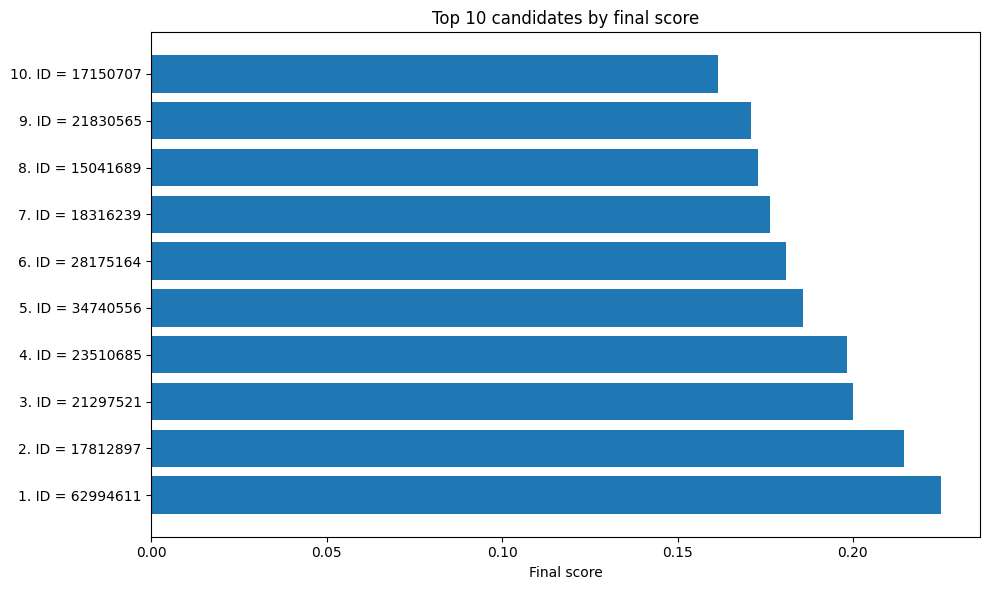

In [ ]:
import matplotlib.pyplot as plt

topn = 10
top = ranked.head(topn)
scores = top['final_score'].values
labels = [ (str(i+1) + ". ID = " + (str(x)[:28]).replace('\n',' ')) for i,x in enumerate(top[ID_COL].astype(str).values) ]

plt.figure(figsize=(10,6))
plt.barh(range(len(scores))[::-1], scores[::-1])
plt.yticks(range(len(scores))[::-1], labels[::-1])
plt.xlabel("Final score")
plt.title(f"Top {topn} candidates by final score")
plt.tight_layout()
plt.show()


## Observation

The resume screening system demonstrates effective candidate differentiation by combining semantic similarity between resumes and the job description with explicit skill matching. Candidates ranked at the top show strong alignment with the role, both in the language used in their resumes and in the presence of required skills. Mid-ranked candidates typically demonstrate partial alignment but are missing one or more key skills, which lowers their overall score. Lower-ranked candidates show limited relevance to the job description or lack critical skills, even if they list several general competencies. Overall, the ranking results indicate that the model is consistently prioritizing candidates based on role fit, supporting recruiters in focusing their attention on the most relevant applicants while keeping final hiring decisions human-led.